<a href="https://colab.research.google.com/github/Aravinda89/multi_label_classification/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai==2.0.19 fastcore==1.3.2

     |████████████████████████████████| 188 kB 4.4 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 748.8 MB 17 kB/s 
     |████████████████████████████████| 5.9 MB 33.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.6.0 which is inco

In [2]:
from fastai.vision.all import *
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F


In [52]:
import fastai
print(fastai.__version__)

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

2.0.19
Mounted at /content/gdrive


In [3]:
path = untar_data(URLs.CAMVID)

In [5]:
ls /root/.fastai/data/camvid/

codes.txt  images/  labels/  valid.txt


In [6]:
code = (path/'codes.txt').read_text()
code

'Animal\nArchway\nBicyclist\nBridge\nBuilding\nCar\nCartLuggagePram\nChild\nColumn_Pole\nFence\nLaneMkgsDriv\nLaneMkgsNonDriv\nMisc_Text\nMotorcycleScooter\nOtherMoving\nParkingBlock\nPedestrian\nRoad\nRoadShoulder\nSidewalk\nSignSymbol\nSky\nSUVPickupTruck\nTrafficCone\nTrafficLight\nTrain\nTree\nTruck_Bus\nTunnel\nVegetationMisc\nVoid\nWall\n'

In [7]:
valid = (path/'valid.txt').read_text()
valid

'0016E5_07959.png\n0016E5_07961.png\n0016E5_07963.png\n0016E5_07965.png\n0016E5_07967.png\n0016E5_07969.png\n0016E5_07971.png\n0016E5_07973.png\n0016E5_07975.png\n0016E5_07977.png\n0016E5_07979.png\n0016E5_07981.png\n0016E5_07983.png\n0016E5_07985.png\n0016E5_07987.png\n0016E5_07989.png\n0016E5_07991.png\n0016E5_07993.png\n0016E5_07995.png\n0016E5_07997.png\n0016E5_07999.png\n0016E5_08001.png\n0016E5_08003.png\n0016E5_08005.png\n0016E5_08007.png\n0016E5_08009.png\n0016E5_08011.png\n0016E5_08013.png\n0016E5_08015.png\n0016E5_08017.png\n0016E5_08019.png\n0016E5_08021.png\n0016E5_08023.png\n0016E5_08025.png\n0016E5_08027.png\n0016E5_08029.png\n0016E5_08031.png\n0016E5_08033.png\n0016E5_08035.png\n0016E5_08037.png\n0016E5_08039.png\n0016E5_08041.png\n0016E5_08043.png\n0016E5_08045.png\n0016E5_08047.png\n0016E5_08049.png\n0016E5_08051.png\n0016E5_08053.png\n0016E5_08055.png\n0016E5_08057.png\n0016E5_08059.png\n0016E5_08061.png\n0016E5_08063.png\n0016E5_08065.png\n0016E5_08067.png\n0016E5_08

In [8]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [9]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

In [10]:
path_im = path/'images'
path_lbl = path/'labels'

In [11]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

In [12]:
len(fnames)

701

In [13]:
fnames[:3]

(#3) [Path('/root/.fastai/data/camvid/images/0016E5_05460.png'),Path('/root/.fastai/data/camvid/images/0006R0_f03150.png'),Path('/root/.fastai/data/camvid/images/0016E5_02400.png')]

In [14]:
lbl_names[:3]

(#3) [Path('/root/.fastai/data/camvid/labels/Seq05VD_f03510_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_08035_P.png'),Path('/root/.fastai/data/camvid/labels/0016E5_08123_P.png')]

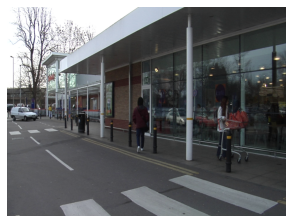

In [15]:
img_fn = fnames[1]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

In [16]:
# ls /root/.fastai/data/camvid/labels
# 0006R0_f02490_P.png  0016E5_07860_P.png  Seq05VD_f03420_P.png

In [17]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

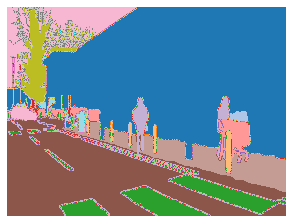

In [18]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [19]:
tensor(msk)

tensor([[21, 21, 21,  ...,  4,  4,  4],
        [21, 21, 21,  ...,  4,  4,  4],
        [21, 21, 21,  ...,  4,  4,  4],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]], dtype=torch.uint8)

In [20]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [21]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [22]:
sz = msk.shape; sz

(720, 960)

In [23]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [24]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [25]:
dls = camvid.dataloaders(path/'images', bs=8)

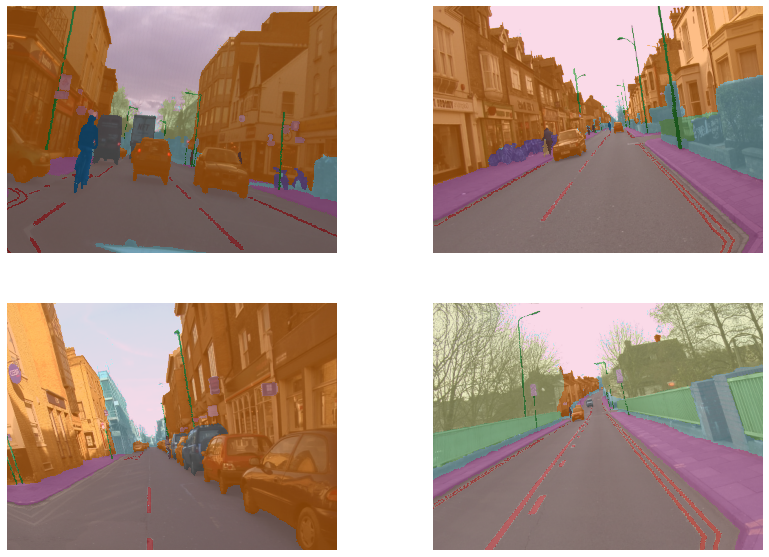

In [26]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [27]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [28]:
dls.vocab = codes

In [29]:
name2id = {v:k for k,v in enumerate(codes)}

In [30]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In [31]:
void_code = name2id['Void']

In [32]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [33]:
opt = ranger

In [74]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)


In [75]:
learn.summary()

DynamicUnet (Input shape: ['8 x 3 x 360 x 480'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               8 x 64 x 180 x 240   9,408      False     
________________________________________________________________
BatchNorm2d          8 x 64 x 180 x 240   128        True      
________________________________________________________________
ReLU                 8 x 64 x 180 x 240   0          False     
________________________________________________________________
MaxPool2d            8 x 64 x 90 x 120    0          False     
________________________________________________________________
Conv2d               8 x 64 x 90 x 120    36,864     False     
________________________________________________________________
BatchNorm2d          8 x 64 x 90 x 120    128        True      
________________________________________________________________
ReLU                 8 x 64 x 90 x 120    0          False     
_________________________________________________

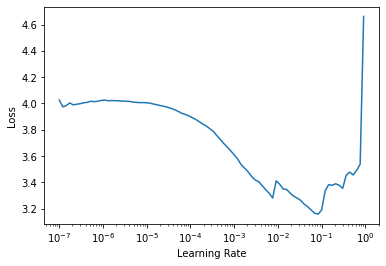

In [76]:
lr_min,lr_steep = learn.lr_find()

In [77]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 1.20e-03


In [ ]:
learn.fit_flat_cos(3, slice(8.32e-03))

epoch,train_loss,valid_loss,acc_camvid,time
0,1.696512,1.363918,0.573121,03:11
1,1.199251,0.882579,0.746787,03:09


In [70]:
# learn.export('/content/gdrive/MyDrive/models/seg1.pkl')
learn.save('/content/gdrive/MyDrive/models/seg1')
# learn.load('/content/gdrive/MyDrive/models/seg1');

In [73]:
learn.show_results()

ValueError: ignored

In [71]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(12, lrs)